### NOTE: 

- The NB was originally developed on Kaggle: https://www.kaggle.com/code/yogendrayatnalkar/finetuning-segment-anything 
- Related Github Repository: https://github.com/yogendra-yatnalkar/SAM-Automatic-Semantic-Segmentation 

# Task: 
## Semantically segment objects from image **AUTOMATICALLY** with the help of **META AI SAM**, without PROMPTS/TRAINING

---

### Segment all the pepperoni pieces from the pizza topping

![](https://i2.wp.com/lifemadesimplebakes.com/wp-content/uploads/2014/09/Classic-Pepperoni-Pizza-1.jpg)

--- 

## Approach: 

![](https://raw.githubusercontent.com/yogendra-yatnalkar/SAM-Automatic-Semantic-Segmentation/main/support-assets/SAM-Automatic-Semantic-Segmentation.png)

**1. Automatic Mask Generation (AMG)**

Utilizing the Segment Anything Model (SAM) from the MetaAI SAM repository, perform instance segmentation on the entire image. This process will identify and isolate individual objects within the image.

**2. Patch-Embedding Extraction & Single Representation per Instance-Segment**

- For each generated instance-segment, extract the corresponding patch embedding. A patch embedding encapsulates a segment's visual features into a concise vector representation.

- To ensure effective association of each cluster with its corresponding segmentation mask, each instance segmentation mask should have a unique single embedding or single representation. **This mapping allows for the accurate assignment of semantic segmentation classes to individual objects.**

- To achieve this, we can extract all the patch embeddings from the encoder features of SAM and average them per segment.

**3. Clustering for Semantic Segmentation**

Treating each segment as a distinct data point, apply clustering algorithms to group similar segments together. Each resulting cluster represents a semantic segmentation class, encompassing objects with shared visual characteristics.

---
---

### Detailed Explanation

#### Patch Embedding and SAM Encoder

- Extract all patch embeddings from the SAM Encoder.

- The SAM model takes an input of **1024x1024** pixels.

- The default patch size is **16x16** pixels.

- Therefore, the input structure is **64x64x16x16**, where there are 64x64 patches, each with a size of 16x16 pixels.

- The SAM Encoder output is **256x64x64**.

- After shuffling the channels, the output becomes **64x64x256**.

- Observe the input-output transformation:
  
  ```
  64x64x16x16 --> 64x64x256
  ```

- This means that each 16x16 patch is represented by a 256-dimensional embedding vector.

#### Segment Embedding

- For each segment, find the corresponding patches and average their embedding vectors.
- For example, if there are 30 segments identified using Meta SAM Automatic Mask Generator (AMG), iterate through each segment and:
  1. Identify the corresponding patches and obtain their embeddings. For instance, if segment1 corresponds to **3 patches**, its patch embedding will be **3x256**. Similarly, if segment2 corresponds to **10 patches**, its patch embedding will be **10x256**.
  2. Average all the patch embeddings corresponding to that segment to obtain a single embedding vector. As a result, segment1's embedding vector will be **1x256**, segment2's embedding vector will be **1x256**, and so on.
- This process results in a **1x256 embedding vector** for each segment. For 30 segments, the representation will be **30x256**.

#### Semantic Class Clustering

- Cluster the segment embedding vectors using a clustering algorithm, such as **DBScan**. This algorithm is suitable since the number of segments is unknown.
- Each cluster formed represents a distinct semantic class.**


 ## Setting up of SAM model for Automatic Mask Generation

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://i2.wp.com/lifemadesimplebakes.com/wp-content/uploads/2014/09/Classic-Pepperoni-Pizza-1.jpg

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
from sklearn.cluster import DBSCAN
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


PyTorch version: 2.0.0
Torchvision version: 0.15.1
CUDA is available: True


In [3]:
# SAM initial model loading
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
sam_checkpoint = "/kaggle/working/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.9]])
        img[m] = color_mask
    ax.imshow(img)

### Sample image

IMG shape:  (1024, 1024, 3)


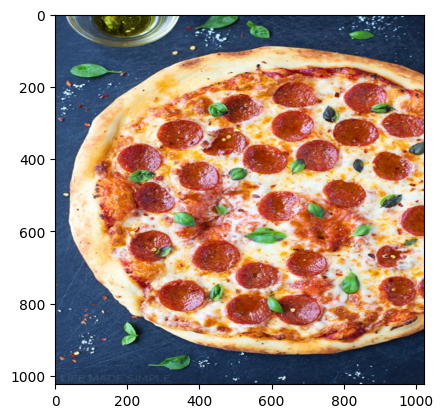

In [5]:
img_path = "/kaggle/working/Classic-Pepperoni-Pizza-1.jpg"
img = cv2.imread(img_path)

# resizing the image to 1024x1024
img = cv2.resize(img, (1024, 1024))
print("IMG shape: ", img.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Sample image instance segmentation with Automatic-Mask-Generation

In [6]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=51,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

### Get the encoder embeddings

In [7]:
mask_generator.predictor.set_image(img_rgb)
enc_emb = mask_generator.predictor.features
enc_emb = enc_emb.to("cpu").numpy()
enc_emb = enc_emb[0].transpose((1,2,0))

print(enc_emb.shape)

(64, 64, 256)


### Generate mask using automatic-mask-generator

In [8]:
masks2 = mask_generator.generate(img_rgb)
masks2 = sorted(masks2, key=(lambda x: x['area']), reverse=True)
print("Number of masks: ", len(masks2))
print("Shape of individual mask: ",masks2[0]['segmentation'].shape)

Number of masks:  264
Shape of individual mask:  (1024, 1024)


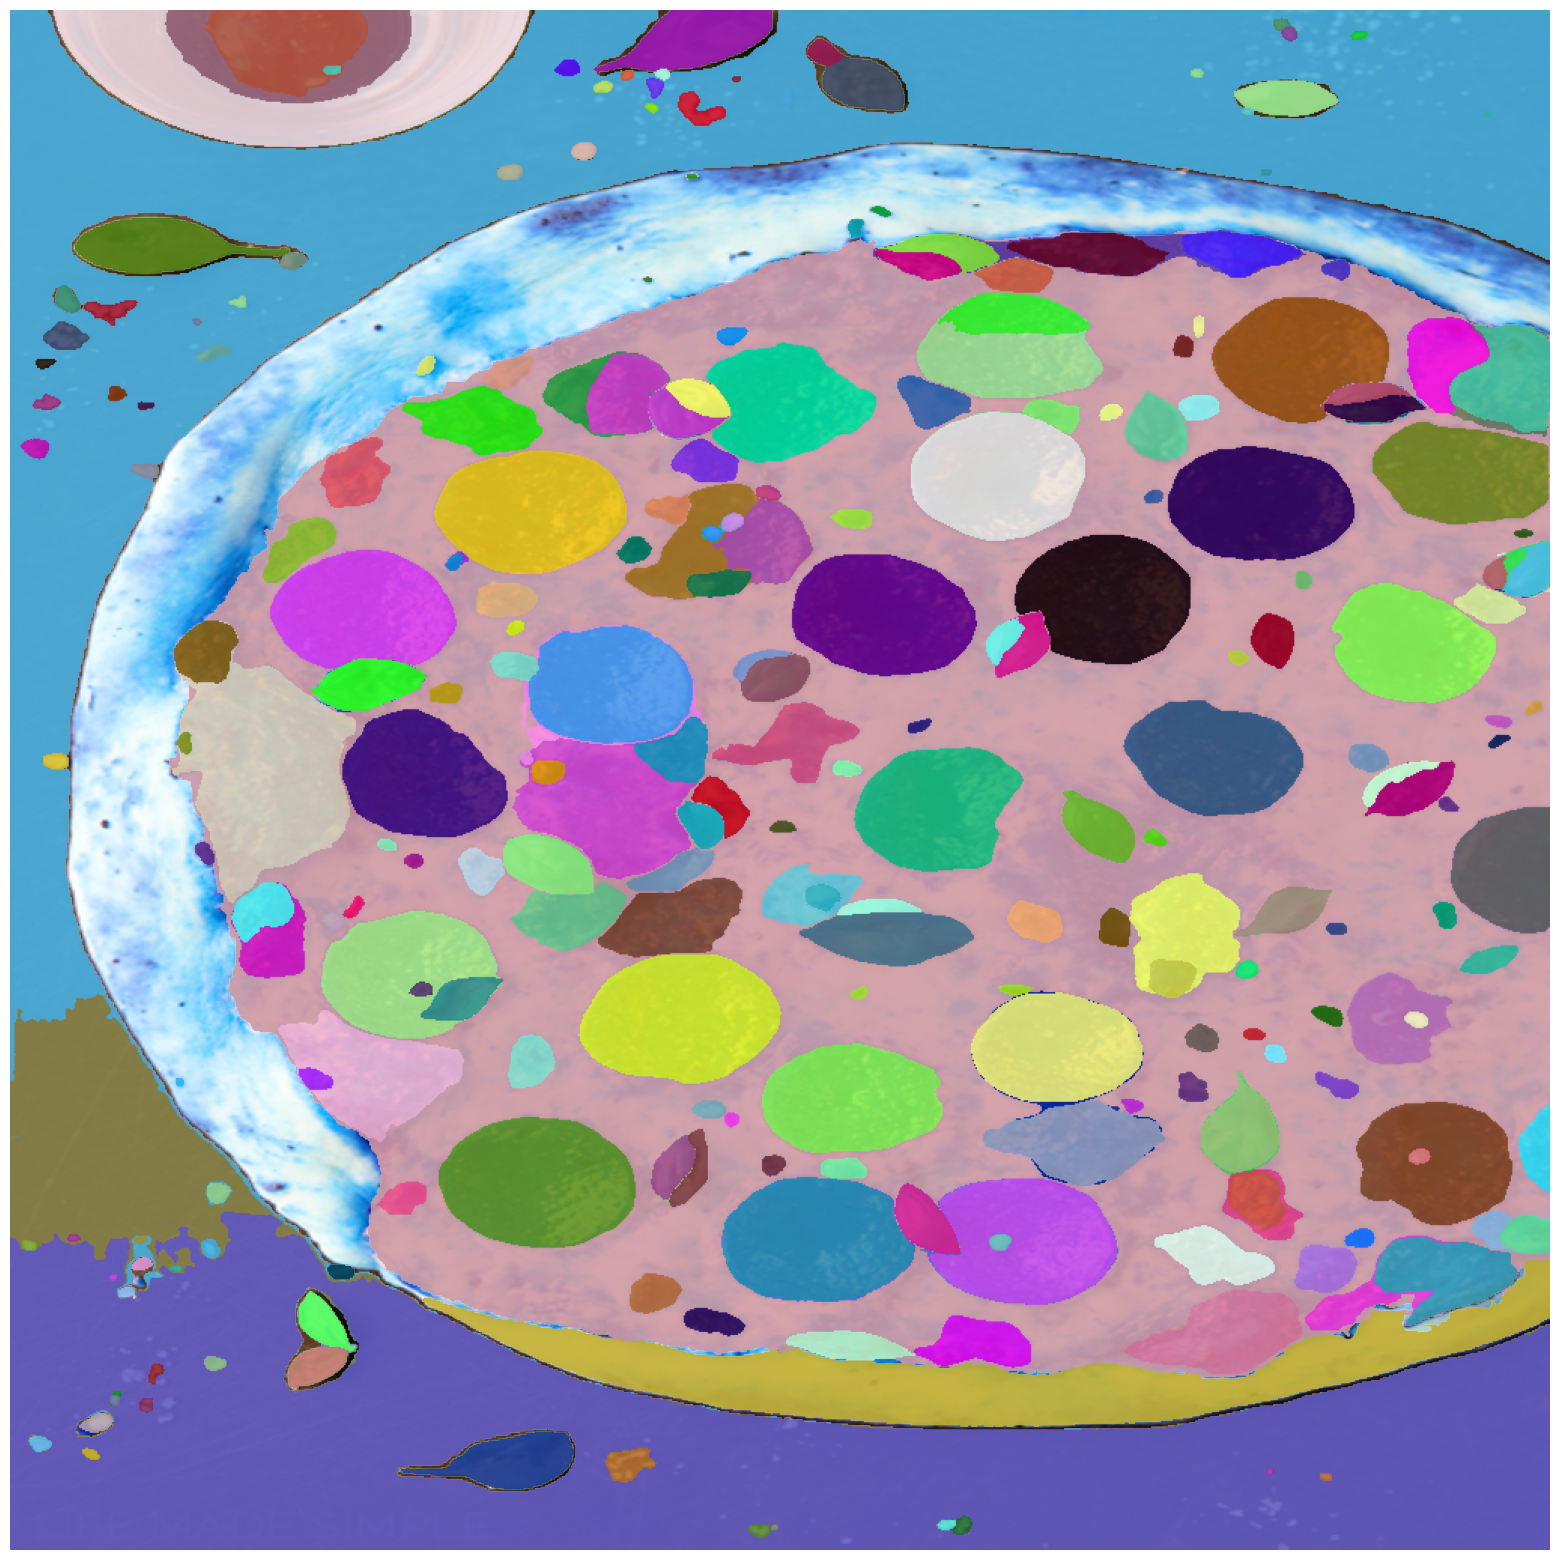

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks2)
plt.axis('off')
plt.show() 

## Get Mask Embedding for each segment: 

#### Mask Embedding = Average of patch embeddings corresponding to individual segment

---

### Notes:

- As we can see, there are 264 masks created using Automatic-Mask-Generator 
- The output-shape of encoder is: 256x64x64 --> which means its a 64x64 image with 256 channels 
- **For each mask, get all the corresponding patch-embedding**
- **The average of all patch-embeddings for a given mask will be termed as "Mask Embedding"**

In [10]:
def get_mask_embedding_using_patch_embeddings(mask, enc_emb, return_all = False):
    # Converting mask of shape 1024x1024 to shape: 64x64x16x16 
    # This assumes that patch size is 16x16 becuase what we mainly need is: 64x64 at the start
    # We are free to change the patch-size accordingly
    split_mask = np.array(np.split(mask, 64, axis = -1))
    split_mask = np.array(np.split(split_mask, 64, axis = -2))
    split_mask = split_mask*1 # split_mask is a mask of shape: 64x64x16x16 
    # split_mask is binary (have value of 0 or 1 not between)
    
    # Converting split_mask of shape: 64x64x16x16 to 64x64 
    # by adding all numbers in every 16x16 grid
    split_mask = np.sum(split_mask, axis = -1)
    split_mask = np.sum(split_mask, axis = -1)
    
    # Get all patch embeddings from this split_mask of 64x64
    # In this split_mask, at all locations where the cell-value is greater than 1,
    # It means that we need to pick the patch-embeddding at this given index (X,Y) value
    patch_locations = np.where(split_mask > 1)
    n_patch_embeddings = enc_emb[patch_locations]
    mask_embedding = n_patch_embeddings.mean(axis = 0, keepdims = False)
    
    if return_all:
        return mask_embedding, patch_locations, n_patch_embeddings
    return mask_embedding

#### NOTE:

- As you can see, post averaging out patch embedding for each segment, we get a mask-embedding of shape: 1x256. 
- Since,we had 264 segments identified, our final vector for 264 segments will be of shape: **264x256**. (we will call it **Mask Embeddings**) 
- These Mask-Embeddings will be passed on to **DBScan for clustering, where each individual cluster formed will be considered as a Semantic Class**.

In [11]:
masks2_embeddings_li = []
for i in range(len(masks2)):
    nth_mask = masks2[i]['segmentation']
    nth_mask_emb = get_mask_embedding_using_patch_embeddings(nth_mask, enc_emb)
    masks2_embeddings_li.append(nth_mask_emb)
    
masks2_embeddings_arr = np.array(masks2_embeddings_li)
print("Mask Embedding shape: ", masks2_embeddings_arr.shape)

Mask Embedding shape:  (264, 256)


## Clustering using DBScan

In [12]:
# Clustering using DB Scan
clustering = DBSCAN(
    eps=0.06,
    min_samples=8,
    metric="cosine"
).fit(masks2_embeddings_arr)

print("Clustering Labels: ", np.unique(clustering.labels_))

Clustering Labels:  [-1  0]


### Label 0 Semantic Mask

Number of items in cluster 0:  (29,)


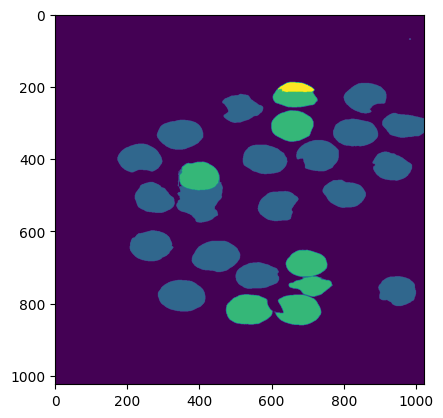

In [13]:
label_0 = np.where(clustering.labels_ == 0)
print("Number of items in cluster 0: ", label_0[0].shape)

lbl0_semantic_seg_mask = masks2[-1]['segmentation']*1
for seg_no in label_0[0]:
    lbl0_semantic_seg_mask += masks2[seg_no]['segmentation']*1

# Plottign the label 0 semantic mask
plt.imshow(lbl0_semantic_seg_mask)

## Final Output

In [14]:
binary_ind = np.where(lbl0_semantic_seg_mask > 0)
mask = lbl0_semantic_seg_mask.copy()
mask[binary_ind] = 1

img_mask = img_rgb.copy()
img_mask[:,:,0] = img_mask[:,:,0]*mask
img_mask[:,:,1] = img_mask[:,:,1]*mask
img_mask[:,:,2] = img_mask[:,:,2]*mask

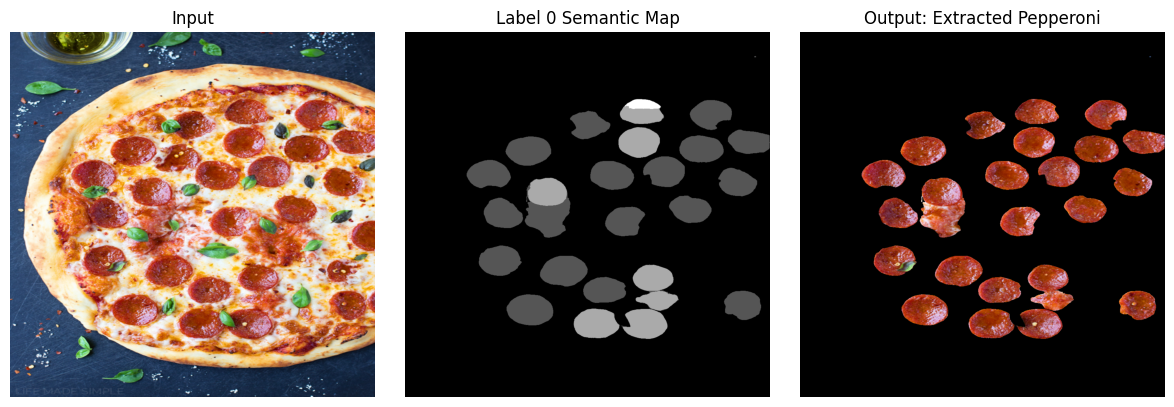

In [15]:
# Create a figure and three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first image on the first subplot
axes[0].imshow(img_rgb, cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')  # Hide axes

# Plot the second image on the second subplot
axes[1].imshow(lbl0_semantic_seg_mask, cmap='gray')
axes[1].set_title('Label 0 Semantic Map')
axes[1].axis('off')  # Hide axes

# Plot the third image on the third subplot
axes[2].imshow(img_mask, cmap='gray')
axes[2].set_title('Output: Extracted Pepperoni')
axes[2].axis('off')  # Hide axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show()